In [5]:
import warnings
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
%matplotlib inline
from matplotlib.pylab import rcParams
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import pmdarima as pm
from sklearn import metrics
from pmdarima.arima import auto_arima
warnings.filterwarnings('ignore')

In [6]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [7]:
flight_data = sns.load_dataset('flights')
flight_data.head()

,year,month,passengers
0,1949,Jan,112
1,1949,Feb,118
2,1949,Mar,132
3,1949,Apr,129
4,1949,May,121


In [8]:
flight_data.tail()

,year,month,passengers
139,1960,Aug,606
140,1960,Sep,508
141,1960,Oct,461
142,1960,Nov,390
143,1960,Dec,432


In [9]:
flight_data.shape

(144, 3)

In [10]:
flight_data.describe()

,year,passengers
count,144.000000,144.000000
mean,1954.500000,280.298611
std,3.464102,119.966317
min,1949.000000,104.000000
25%,1951.750000,180.000000
50%,1954.500000,265.500000
75%,1957.250000,360.500000
max,1960.000000,622.000000


In [11]:
flight_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   year        144 non-null    int64   
 1   month       144 non-null    category
 2   passengers  144 non-null    int64   
dtypes: category(1), int64(2)
memory usage: 2.9 KB


In [12]:
flight_data_pivot = flight_data.pivot(index='month', columns='year', values='passengers')
flight_data_pivot

year,1949,1950,1951,1952,1953,1954,1955,1956,1957,1958,1959,1960
month,,,,,,,,,,,,
Jan,112,115,145,171,196,204,242,284,315,340,360,417
Feb,118,126,150,180,196,188,233,277,301,318,342,391
Mar,132,141,178,193,236,235,267,317,356,362,406,419
Apr,129,135,163,181,235,227,269,313,348,348,396,461
May,121,125,172,183,229,234,270,318,355,363,420,472
Jun,135,149,178,218,243,264,315,374,422,435,472,535
Jul,148,170,199,230,264,302,364,413,465,491,548,622
Aug,148,170,199,242,272,293,347,405,467,505,559,606
Sep,136,158,184,209,237,259,312,355,404,404,463,508


<Figure size 1080x360 with 0 Axes>

<AxesSubplot:xlabel='year', ylabel='month'>

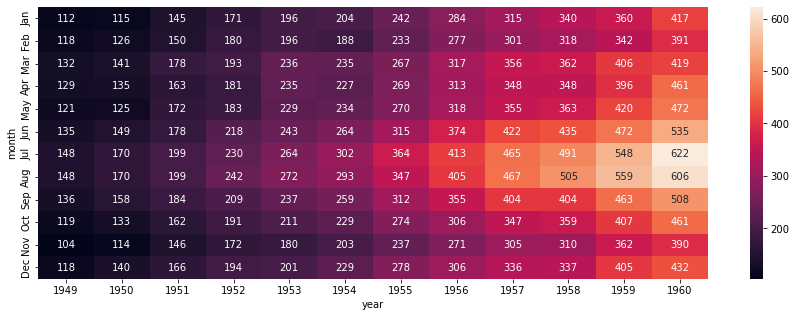

In [15]:
plt.figure(figsize=(15,5))
sns.heatmap(flight_data_pivot, annot=True, fmt='d')

In [17]:
month = pd.date_range('19490131', periods=144, freq='M')
month

DatetimeIndex(['1949-01-31', '1949-02-28', '1949-03-31', '1949-04-30',
               '1949-05-31', '1949-06-30', '1949-07-31', '1949-08-31',
               '1949-09-30', '1949-10-31',
               ...
               '1960-03-31', '1960-04-30', '1960-05-31', '1960-06-30',
               '1960-07-31', '1960-08-31', '1960-09-30', '1960-10-31',
               '1960-11-30', '1960-12-31'],
              dtype='datetime64[ns]', length=144, freq='M')

In [18]:
flight_data['datestamp'] = month
flight_data.head()

,year,month,passengers,datestamp
0,1949,Jan,112,1949-01-31
1,1949,Feb,118,1949-02-28
2,1949,Mar,132,1949-03-31
3,1949,Apr,129,1949-04-30
4,1949,May,121,1949-05-31


In [20]:
data = flight_data[['datestamp', 'passengers']]
data.head()

,datestamp,passengers
0,1949-01-31,112
1,1949-02-28,118
2,1949-03-31,132
3,1949-04-30,129
4,1949-05-31,121


In [21]:
data.describe()

,passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


In [22]:
data.set_index('datestamp', inplace=True)
data.head()

,passengers
datestamp,
1949-01-31,112
1949-02-28,118
1949-03-31,132
1949-04-30,129
1949-05-31,121


<Figure size 1080x720 with 0 Axes>

Text(0.5, 0, 'Time (year)')

Text(0, 0.5, 'Passengers (thousands)')

Text(0.5, 1.0, 'Number of passengers over time')

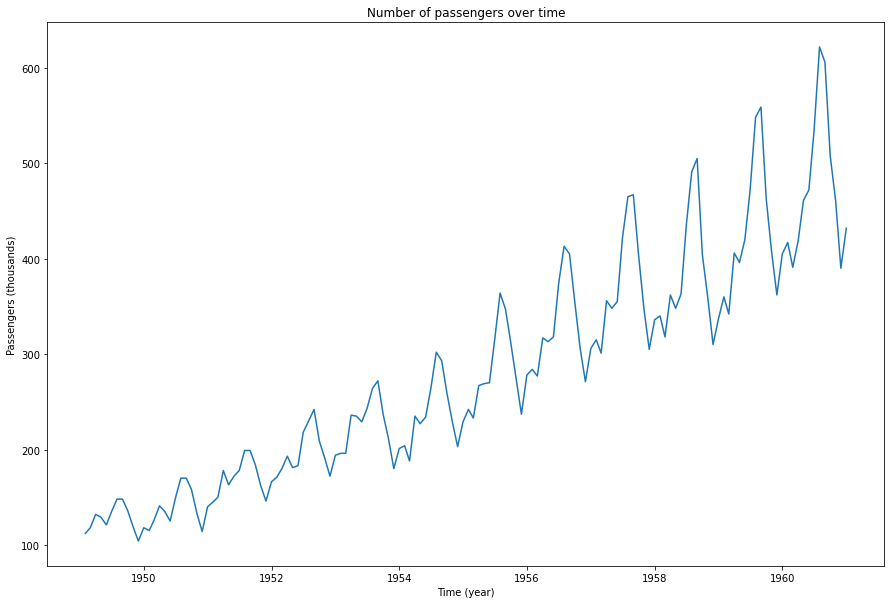

In [24]:
plt.figure(figsize=(15,10))
plt.plot(data)
plt.xlabel('Time (year)')
plt.ylabel('Passengers (thousands)')
plt.title('Number of passengers over time')

In [25]:
decomposition = seasonal_decompose(data, model='multiplicative')

<Figure size 1440x720 with 0 Axes>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

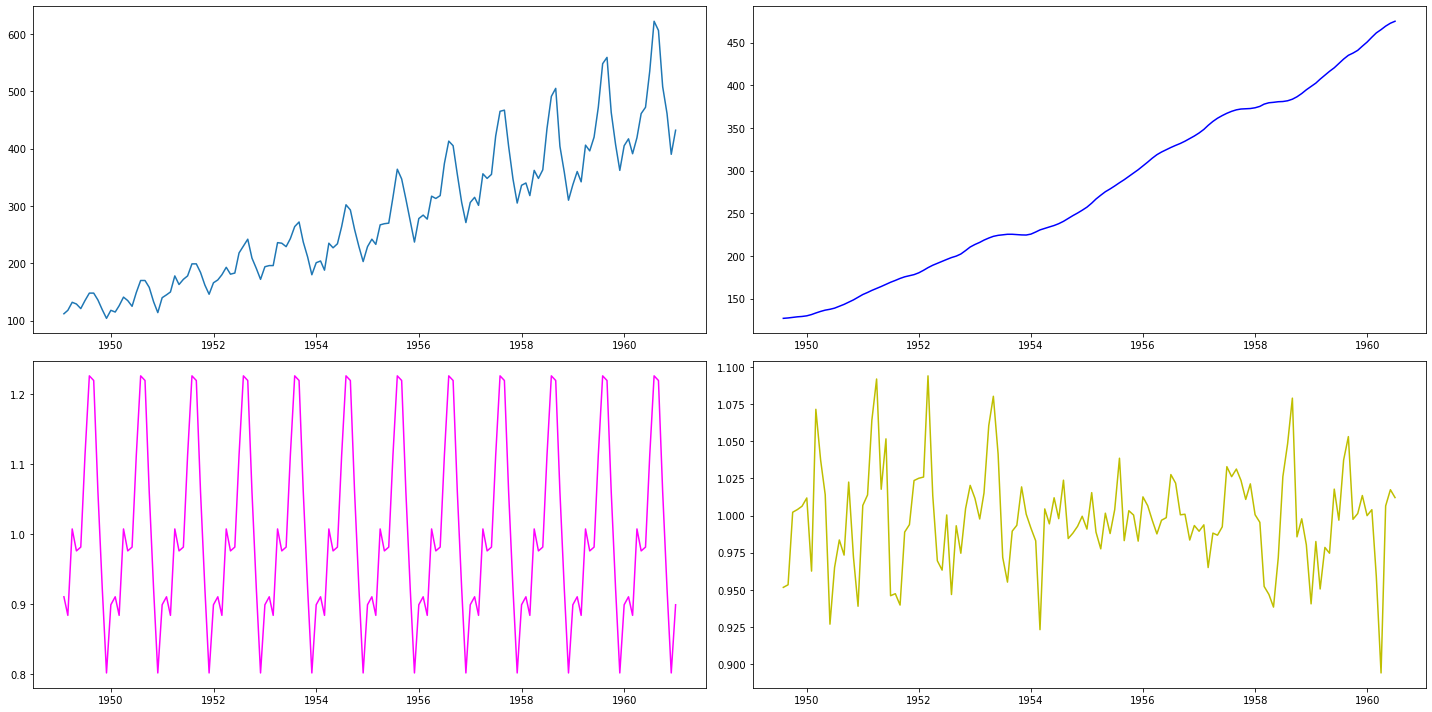

In [33]:
plt.figure(figsize=(20,10))
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(221)
plt.plot(data, label='Original')

plt.subplot(222)
plt.plot(trend, 'b', label='Trend')

plt.subplot(223)
plt.plot(seasonal, color='#ff00ff', label='Seasonality')

plt.subplot(224)
plt.plot(residual, 'y', label='Residuals')

plt.tight_layout()

In [36]:
from pmdarima.arima.stationarity import ADFTest
adf_test = ADFTest(alpha=0.05)
adf_test.should_diff(data)

(0.01, False)

In [37]:
train, test = data[:100], data[100:]
train.shape, test.shape

((100, 1), (44, 1))

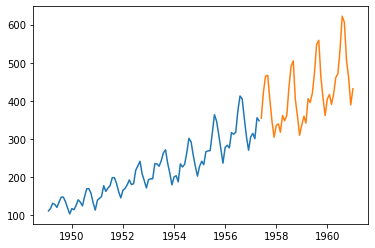

In [38]:
plt.plot(train)
plt.plot(test)

In [39]:
arima_model = auto_arima(train, start_p=1, start_q=1, max_p=8, max_1=8,
                        start_P=0, start_Q=0, max_P=8, max_Q=8,
                        m=12, seasonal=True, trace=True, d=1, D=1,
                        error_action='warn', suppress_warnings=True,
                        stepwise=True, random_state=20, n_fits=30)
arima_model.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=647.341, Time=0.14 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=650.796, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=644.203, Time=0.13 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=644.733, Time=0.20 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=645.995, Time=0.04 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=646.172, Time=0.39 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=646.187, Time=0.32 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=644.600, Time=0.23 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=2.40 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=647.442, Time=0.13 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=646.085, Time=0.25 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=645.647, Time=0.26 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=644.346, Time=0.18 sec
 ARIMA(2,1,1)(1,1,0)[12]             : AIC=647.580, Time=0.34 sec
 ARIMA(1,1,0)(1,1,0)[12] intercept   

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  100
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -319.101
Date:                            Sat, 01 Jan 2022   AIC                            644.203
Time:                                    16:13:57   BIC                            651.601
Sample:                                         0   HQIC                           647.182
                                            - 100                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2434      0.097     -2.512      0.012      -0.433      -0.054
ar.S.L12      -0.2127      0.087     -2.432      0.015      -0.384      -0.041
sigma2        89.1842     14.080      6.334      0.000      61.587     116.781
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 2.43
Prob(Q):                              0.97   Prob(JB):                         0.30
Heteroskedasticity (H):               1.32   Skew:                             0.40
Prob(H) (two-sided):                  0.46   Kurtosis:                         2.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [41]:
prediction = pd.DataFrame(arima_model.predict(n_periods=44), index=test.index, columns=['Predicted_Passengers'])
prediction

,Predicted_Passengers
datestamp,
1957-05-31,353.433649
1957-06-30,406.781321
1957-07-31,447.984392
1957-08-31,438.051605
1957-09-30,391.246543
1957-10-31,344.585092
1957-11-30,309.159969
1957-12-31,345.436075
1958-01-31,353.798005


<Figure size 1080x720 with 0 Axes>

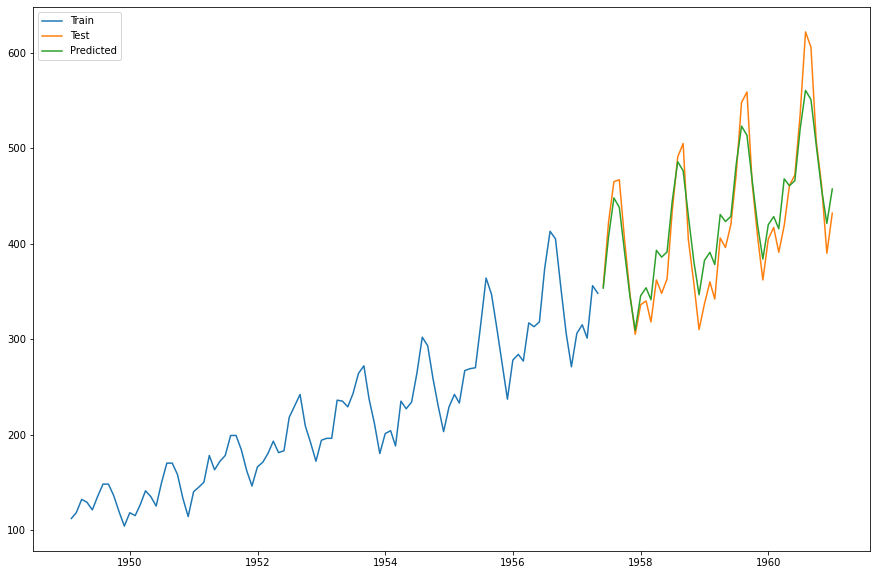

In [43]:
plt.figure(figsize=(15,10))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(prediction, label='Predicted')
plt.legend()

In [45]:
test['Predicted_Passengers'] = prediction
test['Error'] = test['passengers'] - test['Predicted_Passengers']
test

,passengers,Predicted_Passengers,Error
datestamp,,,
1957-05-31,355,353.433649,1.566351
1957-06-30,422,406.781321,15.218679
1957-07-31,465,447.984392,17.015608
1957-08-31,467,438.051605,28.948395
1957-09-30,404,391.246543,12.753457
1957-10-31,347,344.585092,2.414908
1957-11-30,305,309.159969,-4.159969
1957-12-31,336,345.436075,-9.436075
1958-01-31,340,353.798005,-13.798005


In [46]:
metrics.mean_absolute_error(test['passengers'], test['Predicted_Passengers'])

21.53863130206145

In [47]:
metrics.mean_squared_error(test['passengers'], test['Predicted_Passengers'])

686.7476370295576

In [48]:
metrics.median_absolute_error(test['passengers'], test['Predicted_Passengers'])

22.334088597787712

<Figure size 1440x720 with 0 Axes>

<AxesSubplot:>

Text(0.5, 1.0, 'Error Distribution Over Time')

<AxesSubplot:>

((array([-2.15374952, -1.77530174, -1.55088744, -1.38514138, -1.25057432,
         -1.1354892 , -1.03375442, -0.94172868, -0.85705923, -0.7781294 ,
         -0.70377435, -0.63312213, -0.5654989 , -0.50036931, -0.43729746,
         -0.3759202 , -0.31592847, -0.25705362, -0.19905725, -0.14172333,
         -0.08485191, -0.02825382,  0.02825382,  0.08485191,  0.14172333,
          0.19905725,  0.25705362,  0.31592847,  0.3759202 ,  0.43729746,
          0.50036931,  0.5654989 ,  0.63312213,  0.70377435,  0.7781294 ,
          0.85705923,  0.94172868,  1.03375442,  1.1354892 ,  1.25057432,
          1.38514138,  1.55088744,  1.77530174,  2.15374952]),
  array([-49.01296209, -45.43976417, -37.94722115, -36.43507987,
         -36.10959731, -31.32168177, -31.09644078, -30.93740888,
         -28.28863509, -27.2675827 , -25.37181721, -24.92863067,
         -24.66913263, -24.59775919, -23.28686711, -22.76978124,
         -21.89839595, -14.9608103 , -13.7980049 , -12.25232956,
         -11.4295892

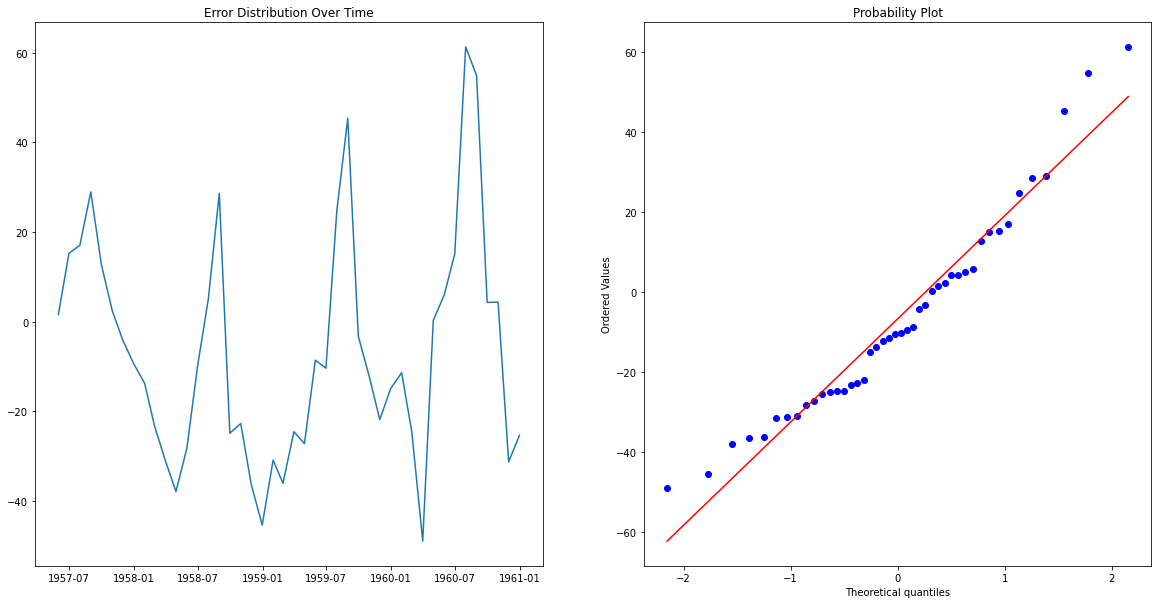

In [51]:
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.plot(test['Error'])
plt.title('Error Distribution Over Time')

plt.subplot(122)
scipy.stats.probplot(test['Error'], plot=plt)

<Figure size 1440x720 with 0 Axes>

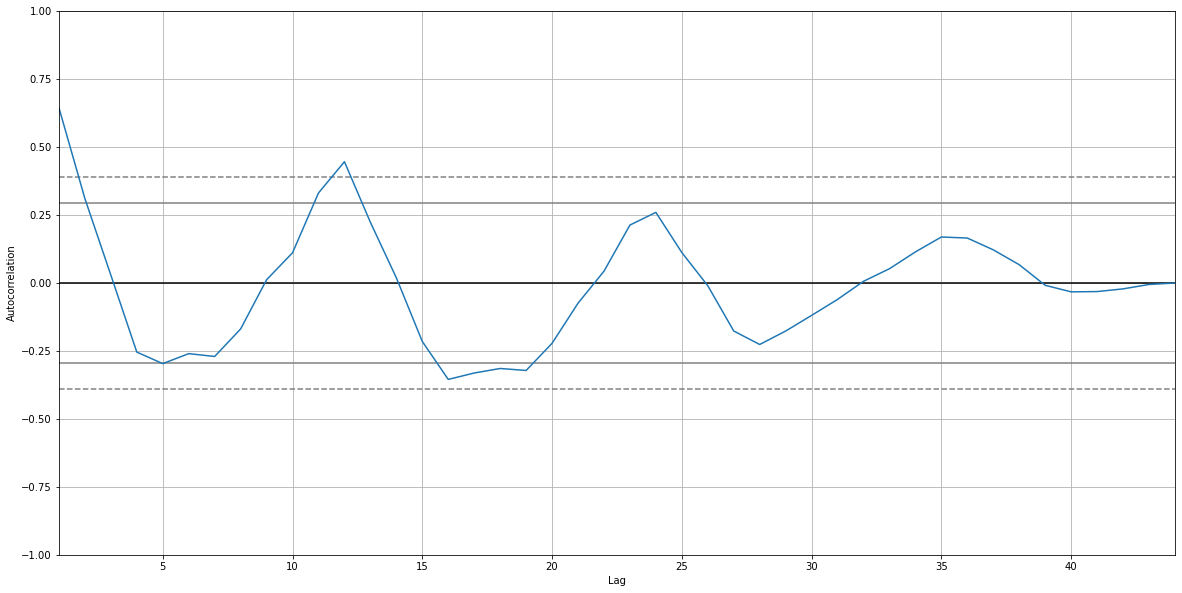

In [52]:
plt.figure(figsize=(20,10))
pm.autocorr_plot(test['Error'])